In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import EmotionalCitiesUtils as ecu
from EmotionalCitiesUtils import _stream_labels
from UbxUtils import read_ubx_file, filter_event

%matplotlib inline
plt.style.use('ggplot')


c:\Users\bfpcr\anaconda3\envs\EmotionalCities\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
stream_root_folder = (r"C:\Users\neurogears\NeuroGEARS Ltd\Emotional Cities - Documents\Experiment Control and Acquisition\Datasets\17_06_2022\Data\2022_08_15_13_50_30")
stream_root_folder = r"C:\Users\bfpcr\Desktop\2022_08_15_13_50_30"

session_time = datetime.datetime.strptime(stream_root_folder.split('\\')[-1], '%Y_%m_%d_%H_%M_%S')


In [3]:
#Load GPS data
#We will also use the first gps timestamp as a reference for the whole experiment
#this usually takes a while...
ubx_data = read_ubx_file(stream_root_folder + r"\\" +  "ubx.bin")

## For now lets use the harp timestamps of the messages...
ubx_harp_timestamp = pd.read_csv(stream_root_folder + r"\\ubx_harp_ts.csv", header = None, names = ('Seconds', 'Class', 'Identity'))
if (ubx_data["Class"] == ubx_harp_timestamp['Class']).all():
    ubx_data['Seconds'] = ubx_harp_timestamp['Seconds']
    ubx_data = ubx_data.set_index('Seconds')
    ubx_data.index = pd.to_timedelta(ubx_data.index, 's')
else:
    print(f'Something is wrong...')


Opening file C:\Users\bfpcr\Desktop\2022_08_15_13_50_30\\ubx.bin...
Done.


### Load position data

In [4]:
gps_time_reference = filter_event(ubx_data, "NAV-PVT").iloc[0]
utc_time = datetime.datetime(
    year = gps_time_reference.Message.year, 
    month = gps_time_reference.Message.month, 
    day = gps_time_reference.Message.day, 
    hour = gps_time_reference.Message.hour,
    minute = gps_time_reference.Message.min,
    second = gps_time_reference.Message.second)

#Sum this value to harp timestamps to get UTC
harp_offset = (utc_time - gps_time_reference.name).timestamp()
ubx_data.index = ubx_data.index + pd.to_timedelta(harp_offset, 's')

TypeError: unsupported operand type(s) for +: 'TimedeltaArray' and 'float'

In [10]:
## Plot position data
import geopandas as gpd
import tilemapbase
#tilemapbase.init(create=True) #Must run the first time to create the cache file
NavData = filter_event(ubx_data, "NAV-HPPOSLLH")

NavData.insert(NavData.shape[1], "Lat", NavData.apply(lambda x : x.Message.lat, axis = 1), False)
NavData.insert(NavData.shape[1], "Lon", NavData.apply(lambda x : x.Message.lon, axis = 1), False)
NavData.insert(NavData.shape[1], "Height", NavData.apply(lambda x : x.Message.height, axis = 1), False)
NavData.insert(NavData.shape[1], "Time", NavData.apply(lambda x : x.Message.iTOW, axis = 1), False)


In [110]:
## Load biodata
from scipy import signal
ecg = ecu.read_harp_bin(ecu.get_stream_path("Biodata_ECG",
                        root = stream_root_folder,
                        ext =""), time_offset=harp_offset)
ecg = ecg["Value0"].iloc[np.arange(len(ecg))[::4]].astype(np.float64) #Data repeats every 4 samples
#This should not be necessary as the acquisition rate seems pretty stable, but just in case....
resmaple_rate = datetime.timedelta(seconds = 1.0/250.0) #Period (1/Hz)
resampled = ecg.resample(resmaple_rate).interpolate(method = 'linear')
#High-pass the signal
resampled = ecu.butter_highpass_filter(ecg,5,250.0)
#Assume maximum HR of 300bpm ~ 5Hz ~ 0.2 Seconds
peaks, _  = signal.find_peaks(resampled, height = 800, distance = 0.2 * 250.0 )
peaks = pd.DataFrame(ecg.index.values[peaks])
peaks = peaks.rename(columns={0: "Seconds"})
peaks = peaks.set_index("Seconds")
peaks['Dummy'] = 1


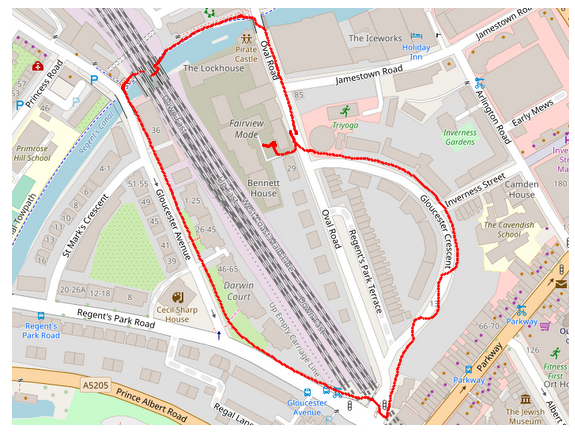

In [16]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
tiles = tilemapbase.tiles.build_OSM()
extent = tilemapbase.Extent.from_lonlat(np.min(NavData['Lon'].values), np.max(NavData['Lon'].values),
                                        np.min(NavData['Lat'].values), np.max(NavData['Lat'].values))
extent = extent.to_aspect(4/3).with_scaling(0.6)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plotter = tilemapbase.Plotter(extent, tiles, width=600)
plotter.plot(ax)

path = [tilemapbase.project(x,y) for x,y in zip(NavData['Lon'].values, NavData['Lat'].values)]
x, y = zip(*path)

ax.scatter(x, y, c = 'r', s = 3)
plt.show()


C:\Users\bfpcr\AppData\Local\Temp\ipykernel_11896\3047344068.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resampled_NavData['HR'].iloc[i] = (len(peaksslice) / sampling_dt.total_seconds())


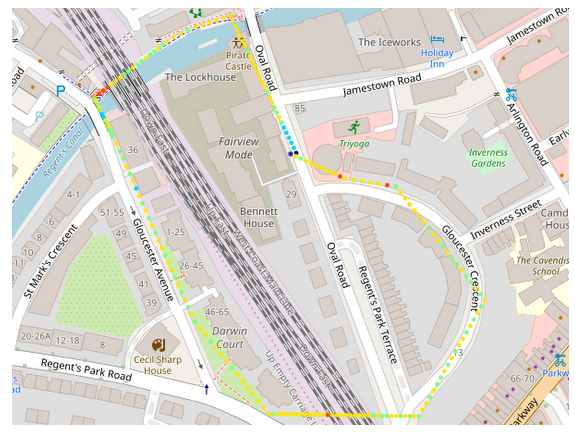

In [170]:
## Heart Rate during the walk
sampling_dt = datetime.timedelta(seconds = 5)
offset_0 = NavData.index.values[0]

resampled_NavData = NavData.resample(sampling_dt, origin='epoch', offset=offset_0).interpolate(method = 'linear')
resampled_NavData['HR'] = np.NAN
for i in np.arange(len(resampled_NavData)):
    timeslice = (peaks.index >= resampled_NavData.index[i] - sampling_dt/2) & (peaks.index < resampled_NavData.index[i] + sampling_dt/2)
    peaksslice = peaks[timeslice]
    resampled_NavData['HR'].iloc[i] = (len(peaksslice) / sampling_dt.total_seconds())
resampled_NavData['HR'] = resampled_NavData['HR'] * 60 #in bpms

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
tiles = tilemapbase.tiles.build_OSM()
extent = tilemapbase.Extent.from_lonlat(np.min(resampled_NavData['Lon'].values), np.max(resampled_NavData['Lon'].values),
                                        np.min(resampled_NavData['Lat'].values), np.max(resampled_NavData['Lat'].values))
extent = extent.to_aspect(4/3).with_scaling(0.7)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plotter = tilemapbase.Plotter(extent, tiles, width=600)
plotter.plot(ax)

path = [tilemapbase.project(x,y) for x,y in zip(resampled_NavData['Lon'].values, resampled_NavData['Lat'].values)]
x, y = zip(*path)

ax.scatter(x, y, c = resampled_NavData['HR'].values, s =15, cmap = 'jet' )
plt.show()